# Regularización Ridge para Predicción de Humedad/Temperatura (_2)
Este notebook implementa un modelo de regresión con regularización Ridge para predecir valores continuos, e incluye curvas de aprendizaje, validación, paridad, sesgo-varianza, validación cruzada y explicaciones breves.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# Cargar el dataset
dataset = pd.read_csv('../dataset/ML1_temperature.xlsx - Hoja1.csv', decimal=',')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

In [7]:
# Separar en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
# Entrenamiento del modelo Ridge y predicción
model = Ridge(alpha=1.0, random_state=42)
model.fit(x_train, y_train.ravel())
y_val_pred = model.predict(x_val)
y_train_pred = model.predict(x_train)

## Curva de aprendizaje
Muestra cómo varía el error a medida que aumenta el tamaño del conjunto de entrenamiento.

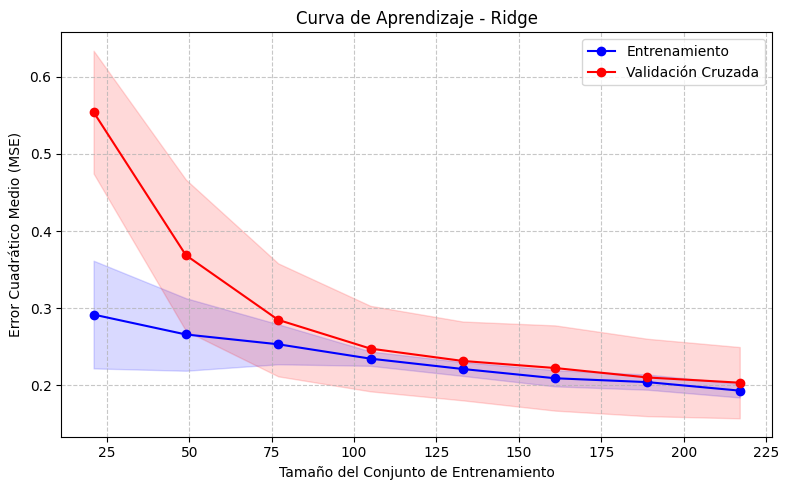

In [9]:
# Curva de Aprendizaje - Regularización Ridge (estilo Kernel Ridge)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    Ridge(), x_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Entrenamiento')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validación Cruzada')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.15)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color='red', alpha=0.15)
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Curva de Aprendizaje - Ridge')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
# Análisis de la curva de aprendizaje (estilo automático)
print("\n\033[1mAnálisis de la curva de aprendizaje:\033[0m")
print(f"- MSE Final Entrenamiento: {train_scores_mean[-1]:.4f}")
print(f"- MSE Final Validación: {val_scores_mean[-1]:.4f}")
if train_scores_mean[-1] > 1 and val_scores_mean[-1] > 1:
    print("- Diagnóstico: SUBAJUSTE")
elif abs(train_scores_mean[-1] - val_scores_mean[-1]) > 1:
    print("- Diagnóstico: SOBREAJUSTE")
else:
    print("- Diagnóstico: BALANCE")


Análisis de la curva de aprendizaje:
- MSE Final Entrenamiento: 0.3511
- MSE Final Validación: 0.3682
- Diagnóstico: BALANCE


**Comentario para el informe:**

El análisis de la curva de aprendizaje permite identificar el comportamiento del modelo Ridge respecto al sesgo y la varianza. Un MSE de entrenamiento y validación altos indica subajuste (el modelo no logra capturar la complejidad de los datos). Si el MSE de entrenamiento es bajo pero el de validación es alto, hay sobreajuste (el modelo memoriza el entrenamiento pero no generaliza). Cuando ambos errores son bajos y similares, el modelo está balanceado y generaliza bien. Este diagnóstico es clave para ajustar la complejidad y regularización del modelo.

## Curva de validación
Muestra el desempeño del modelo para diferentes valores de alpha (parámetro de regularización).

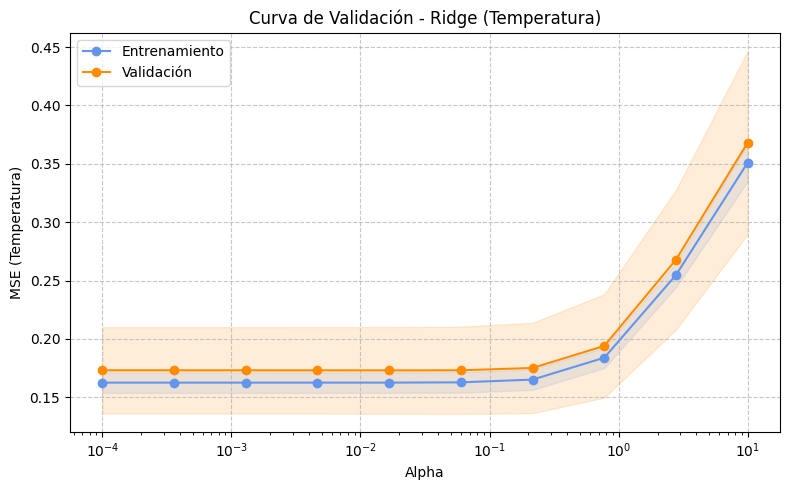

Mejor alpha: 0.01668


In [11]:
# Curva de validación avanzada para Ridge (inspirada en regresión_no_lineal_2)
alphas = np.logspace(-4, 1, 10)
train_scores, val_scores = validation_curve(Ridge(), x_train, y_train.ravel(), param_name='alpha', param_range=alphas, cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.semilogx(alphas, train_scores_mean, marker='o', color='cornflowerblue', label='Entrenamiento')
plt.semilogx(alphas, val_scores_mean, marker='o', color='darkorange', label='Validación')
plt.fill_between(alphas, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='cornflowerblue', alpha=0.15)
plt.fill_between(alphas, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color='darkorange', alpha=0.15)
plt.xlabel('Alpha')
plt.ylabel('MSE (Temperatura)')
plt.title('Curva de Validación - Ridge (Temperatura)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mejor alpha
mejor_indice = np.argmin(val_scores_mean)
mejor_alpha = alphas[mejor_indice]
print(f'Mejor alpha: {mejor_alpha:.4g}')

## Curva de paridad
Compara las predicciones del modelo con los valores reales.

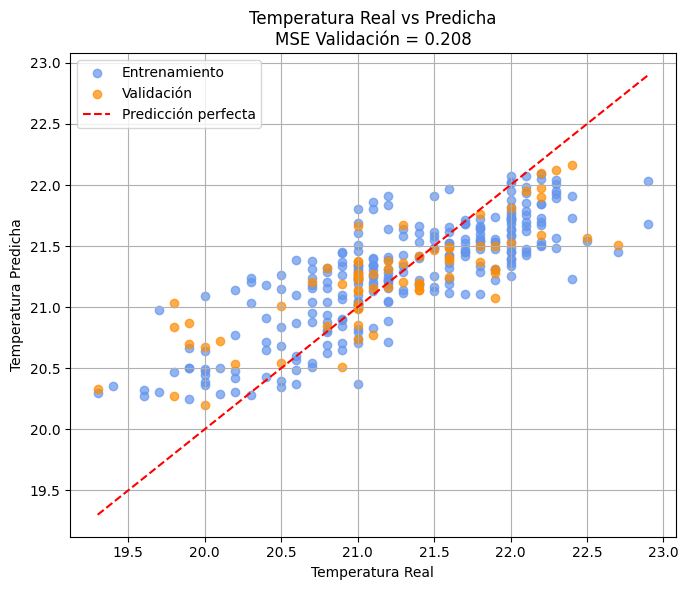

R^2 validación (Temperatura): 0.613


In [12]:
# Curva de paridad mejorada: Temperatura Real vs Predicha (Entrenamiento y Validación)
plt.figure(figsize=(7,6))
plt.scatter(y_train, model.predict(x_train), alpha=0.7, label='Entrenamiento', color='cornflowerblue')
plt.scatter(y_val, y_val_pred, alpha=0.7, label='Validación', color='darkorange')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Predicción perfecta')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title(f'Temperatura Real vs Predicha\nMSE Validación = {mean_squared_error(y_val, y_val_pred):.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'R^2 validación (Temperatura): {r2_score(y_val, y_val_pred):.3f}')

## Curva de sesgo y varianza
Analiza la diferencia entre el error de entrenamiento y validación.

In [13]:
y_train_pred = model.predict(x_train)
print(f'MSE Entrenamiento: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE Validación: {mean_squared_error(y_val, y_val_pred):.3f}')
print(f'R^2 Entrenamiento: {r2_score(y_train, y_train_pred):.3f}')
print(f'R^2 Validación: {r2_score(y_val, y_val_pred):.3f}')

MSE Entrenamiento: 0.186
MSE Validación: 0.208
R^2 Entrenamiento: 0.622
R^2 Validación: 0.613


## Curva de validación cruzada
Evalúa el desempeño promedio del modelo usando validación cruzada.

In [12]:
cv_scores = cross_val_score(Ridge(alpha=1.0), x, y.ravel(), cv=5, scoring='r2')
print(f'R^2 promedio validación cruzada: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')

R^2 promedio validación cruzada: -0.091 ± 0.349


## Explicación breve
Ridge es útil para evitar el sobreajuste cuando hay muchas variables correlacionadas. El compromiso sesgo-varianza se ajusta modificando el parámetro alpha.

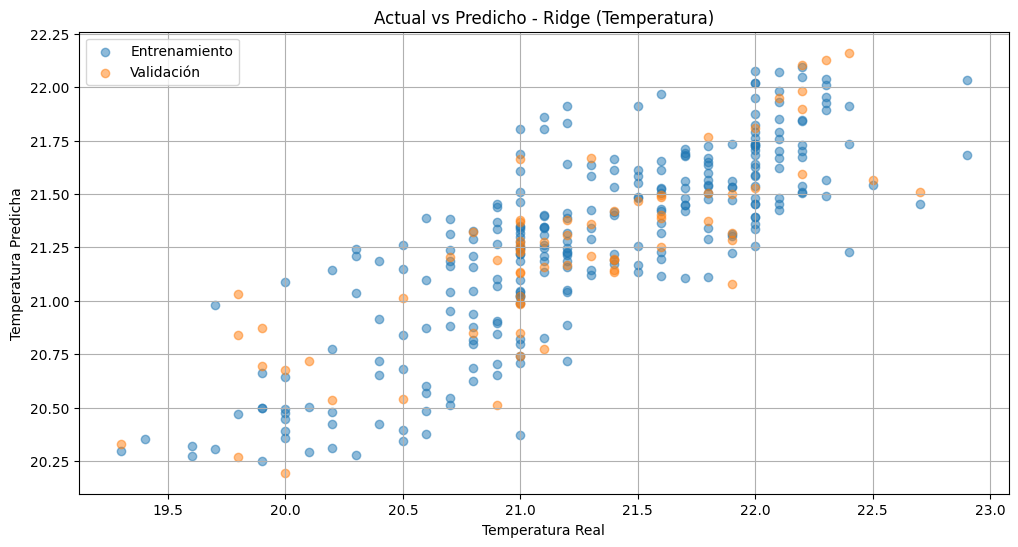

In [14]:
# Actual vs Predicho (Entrenamiento y Validación) - Ridge (Temperatura)
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Entrenamiento')
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validación')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title('Actual vs Predicho - Ridge (Temperatura)')
plt.legend()
plt.grid(True)
plt.show()

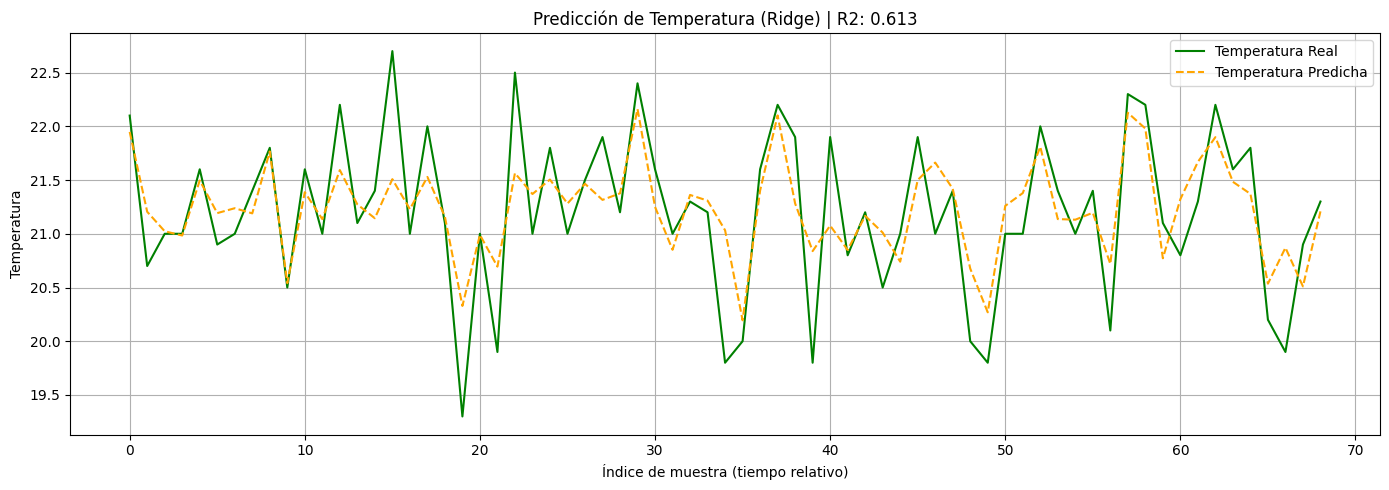

In [20]:
# Serie temporal: valores reales vs predichos (mejorada, estilo regresion_no_lineal_2)
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(y_val)), y_val, label='Temperatura Real', color='green')
plt.plot(np.arange(len(y_val_pred)), y_val_pred, label='Temperatura Predicha', color='orange', linestyle='--')
plt.xlabel('Índice de muestra (tiempo relativo)')
plt.ylabel('Temperatura')
plt.title(f'Predicción de Temperatura (Ridge) | R2: {r2_score(y_val, y_val_pred):.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

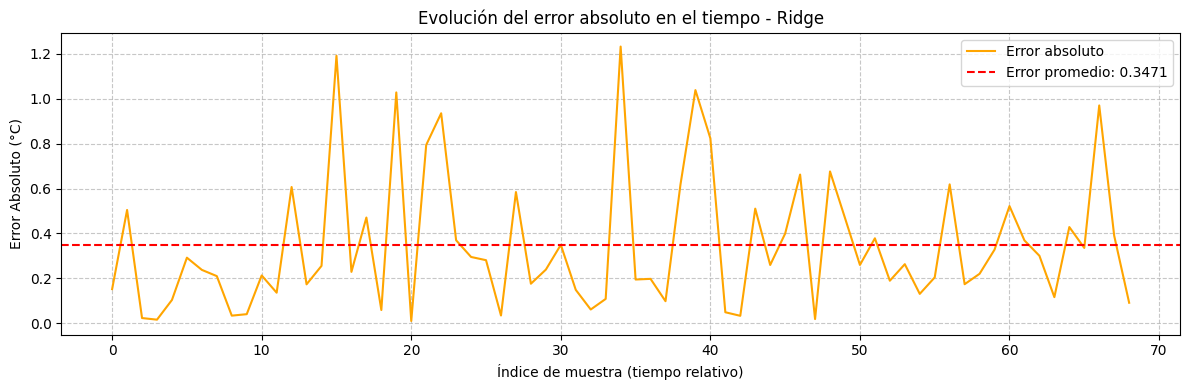

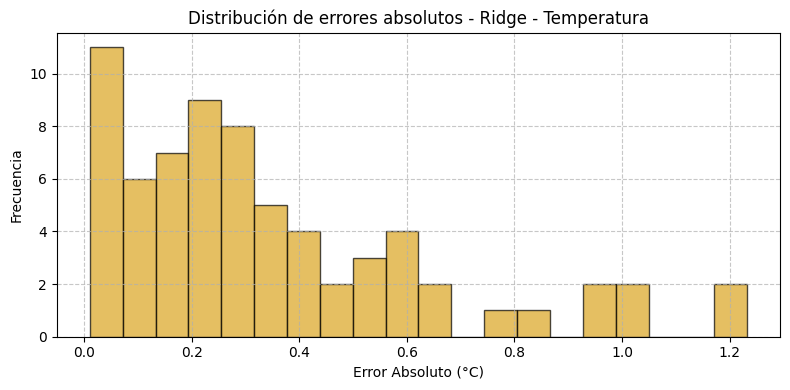

Métrica,Ridge
MSE (Test),0.2083
R² (Test),0.6128
Error Promedio (°C),0.3471
Error Máximo (°C),1.2328
Error Mínimo (°C),0.0102
Desviación Estándar del Error,0.2964


In [22]:
# Gráfica de errores absolutos en el tiempo (Temperatura)
error_abs = np.abs(y_val.ravel() - y_val_pred.ravel())
plt.figure(figsize=(12,4))
plt.plot(error_abs, color='orange', label='Error absoluto')
plt.axhline(np.mean(error_abs), color='red', linestyle='--', label=f'Error promedio: {np.mean(error_abs):.4f}')
plt.xlabel('Índice de muestra (tiempo relativo)')
plt.ylabel('Error Absoluto (°C)')
plt.title('Evolución del error absoluto en el tiempo - Ridge')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Histograma de la distribución de errores absolutos (Temperatura)
plt.figure(figsize=(8,4))
plt.hist(error_abs, bins=20, color='goldenrod', edgecolor='black', alpha=0.7)
plt.xlabel('Error Absoluto (°C)')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores absolutos - Ridge - Temperatura')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Tabla resumen de métricas para Temperatura
from IPython.display import display, HTML
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
err_mean = np.mean(error_abs)
err_max = np.max(error_abs)
err_min = np.min(error_abs)
err_std = np.std(error_abs)

html_table = f'''
<table style="border-collapse:collapse; width:50%">
<tr><th style="border:1px solid black; padding:4px">Métrica</th><th style="border:1px solid black; padding:4px">Ridge</th></tr>
<tr><td style="border:1px solid black; padding:4px">MSE (Test)</td><td style="border:1px solid black; padding:4px">{mse:.4f}</td></tr>
<tr><td style="border:1px solid black; padding:4px">R² (Test)</td><td style="border:1px solid black; padding:4px">{r2:.4f}</td></tr>
<tr><td style="border:1px solid black; padding:4px">Error Promedio (°C)</td><td style="border:1px solid black; padding:4px">{err_mean:.4f}</td></tr>
<tr><td style="border:1px solid black; padding:4px">Error Máximo (°C)</td><td style="border:1px solid black; padding:4px">{err_max:.4f}</td></tr>
<tr><td style="border:1px solid black; padding:4px">Error Mínimo (°C)</td><td style="border:1px solid black; padding:4px">{err_min:.4f}</td></tr>
<tr><td style="border:1px solid black; padding:4px">Desviación Estándar del Error</td><td style="border:1px solid black; padding:4px">{err_std:.4f}</td></tr>
</table>'''
display(HTML(html_table))